# Stock exchange prediction for fun

Import libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


Read and prepare OHLC data, 5 minute bars

In [5]:
# Read 1M OHLCV data from file instead of pdr.DataReader('RTSI','moex',start,end) because moex network source doesn't allow often downloads
#file="/home/dima/projects/stock-predictor/src/main/ipynb/data/RI.RTSI_180101_180313.csv"
df=pd.read_csv("/home/dima/projects/stock-predictor/data/RI.RTSI_180101_180313.csv", 
               parse_dates={'datetime':[2,3]}, 
               index_col='datetime')
#df=df.loc['2018-01-09']
df=df[['<OPEN>','<HIGH>','<LOW>','<CLOSE>','<VOL>']].pct_change()

df.columns=['open','high','low','close','vol']
# Resample 1Min OHLC to 5Min OHLC
df=df.resample('5Min').agg({
        'open': 'first', 
        'high': 'max', 
        'low': 'min', 
        'close': 'last',
        'vol': 'sum'})
df=df.dropna()
df.tail()

,open,high,low,close,vol
datetime,,,,,
2018-03-13 18:25:00,0.000406,0.000242,-0.000429,0.000117,0.784008
2018-03-13 18:30:00,0.000062,0.001162,0.000078,-0.000132,0.030271
2018-03-13 18:35:00,-0.000125,-0.000164,-0.000483,0.000016,0.697699
2018-03-13 18:40:00,0.000070,0.000210,0.000226,0.000000,-1.027860
2018-03-13 18:50:00,0.002018,0.002018,0.002018,0.002018,inf


Prepare predictors and target


In [193]:
predictors=df.reset_index().drop(['datetime'],axis=1)
target=predictors.shift(-1)[['high','low']][:-1]
predictors=predictors[:-1]


In [194]:
predictors.tail()

,open,high,low,close,vol
4886,-0.000179,0.000507,-0.000101,0.000413,0.043194
4887,0.000406,0.000242,-0.000429,0.000117,0.784008
4888,0.000062,0.001162,0.000078,-0.000132,0.030271
4889,-0.000125,-0.000164,-0.000483,0.000016,0.697699
4890,0.000070,0.000210,0.000226,0.000000,-1.027860


In [195]:
target.tail()

,high,low
4886,0.000242,-0.000429
4887,0.001162,0.000078
4888,-0.000164,-0.000483
4889,0.000210,0.000226
4890,0.002018,0.002018


Predict with neural network

In [196]:
import numpy as np
import keras
from keras.layers import Dense,BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Split to train and test
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.3, shuffle=False)

# Create the model
model=Sequential()
n_cols = predictors.shape[1]
#model.add(Dense(predictors.columns.size, activation='relu', input_shape=(n_cols,)))
model.add(Dense(int(predictors.columns.size), batch_size=10))
#model.add(Dense(int(predictors.columns.size), input_shape=(10,5)))
#model.add(BatchNormalization())
#model.add(Dense(50, input_dim=5, kernel_initializer='uniform'))
#model.add(BatchNormalization())
model.add(Dense(int(predictors.columns.size), activation='selu'))

# High/Low prediction output
model.add(Dense(2, activation='relu'))

optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

# Fit
#early_stopping = EarlyStopping(patience=2)
#model.fit(X_train.values, y_train.values, validation_split=0.3, epochs=30, callbacks=[early_stopping], shuffle=False, verbose=True)
model.fit(X_train.values, y_train.values, validation_split=0.3, epochs=20, shuffle=True, verbose=True)

# Predict
y=model.predict(X_test)
pd.DataFrame(y).tail()



Train on 2396 samples, validate on 1027 samples
Epoch 1/20
2396/2396 [==============================] - 2s 689us/step - loss: nan - acc: 0.9896 - val_loss: nan - val_acc: 0.9971
Epoch 2/20
2396/2396 [==============================] - 0s 47us/step - loss: nan - acc: 0.9979 - val_loss: nan - val_acc: 0.9971
Epoch 3/20
2396/2396 [==============================] - 0s 48us/step - loss: nan - acc: 0.9979 - val_loss: nan - val_acc: 0.9971
Epoch 4/20
2396/2396 [==============================] - 0s 47us/step - loss: nan - acc: 0.9979 - val_loss: nan - val_acc: 0.9971
Epoch 5/20
2396/2396 [==============================] - 0s 49us/step - loss: nan - acc: 0.9979 - val_loss: nan - val_acc: 0.9971
Epoch 6/20
2396/2396 [==============================] - 0s 48us/step - loss: nan - acc: 0.9979 - val_loss: nan - val_acc: 0.9971
Epoch 7/20
2396/2396 [==============================] - 0s 48us/step - loss: nan - acc: 0.9979 - val_loss: nan - val_acc: 0.9971
Epoch 8/20
2396/2396 [==========================

,0,1
1463,NaN,NaN
1464,NaN,NaN
1465,NaN,NaN
1466,NaN,NaN
1467,NaN,NaN


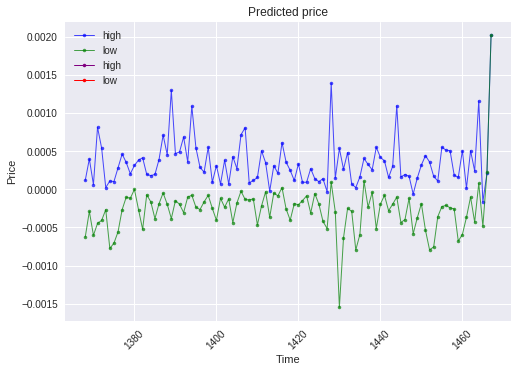

In [197]:


#from mpl_finance import candlestick_ohlc
plt.style.use('seaborn')
#fig,ax = plt.subplots()
#quotes=df.reset_index()
#quotes.columns=['date','open','high','low','close','vol']
#quotes=quotes[['date','open','high','low','close']]
#quotes['date'] = quotes['date'].apply(mdates.date2num)
#candlestick_ohlc(ax,quotes.values, width=.001, colorup='blue', colordown='green')
#candlestick_ohlc(ax,quotes.values, width=.03, alpha=0.5, colorup='black', colordown='red')

#plt.plot(df.index, df.high, marker='.', linestyle='solid', color='b', alpha=0.5, linewidth=1)
#plt.plot(df.index, df.low, marker='.', linestyle='solid', color='green', alpha=0.5, linewidth=1)
last_points=100
original=pd.DataFrame(y_test).reset_index()[-last_points:]
plt.plot(original['high'], marker='.', linestyle='solid', color='b', alpha=0.7, linewidth=1)
plt.plot(original['low'], marker='.', linestyle='solid', color='green', alpha=0.7, linewidth=1)

actual=pd.DataFrame(y, columns=['high','low']).reset_index()[-last_points:]
plt.plot(actual['high'], marker='.', linestyle='solid', color='purple', alpha=1, linewidth=1)
plt.plot(actual['low'], marker='.', linestyle='solid', color='red', alpha=1, linewidth=1)

#plt.ylim(min(original['high']),max(original['high']))

plt.title('Predicted price')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Price')
plt.legend()
plt.show()

The first result looks not very encouraging, doesn't it? :)

.. To be continue ...